In [3]:
!pip -q install -U datasets transformers accelerate scikit-learn

# Install required libraries (run once)
# datasets: for HuggingFace Dataset object
# transformers: for DistilBERT + Trainer API
# accelerate: speeds up training
# scikit-learn: for evaluation metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from datasets import Dataset
# Transformers utilities for tokenization, model, training pipeline
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    set_seed
)
# Evaluation metrics from scikit-learn
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    roc_auc_score,
    precision_recall_curve,
    average_precision_score
)


C:\Users\ARCHANA\anaconda3\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [4]:
# Load the dataset
df=pd.read_csv("DisasterTweets.csv")
print("Shape:", df.shape)
print("Columns:", list(df.columns))
df.head()

Shape: (2559, 13)
Columns: ['Name', 'UserName', 'Timestamp', 'Verified', 'Tweets', 'Comments', 'Retweets', 'Likes', 'Impressions', 'Tags', 'Tweet Link', 'Tweet ID', 'Disaster']


,Name,UserName,Timestamp,Verified,Tweets,Comments,Retweets,Likes,Impressions,Tags,Tweet Link,Tweet ID,Disaster
0,Drought Center,@DroughtCenter,2024-02-29T13:30:07.000Z,False,US Drought Monitor 2-29-24\n\nHappy Leap Day! ...,0,17,13,18000,"['#droughtmonitor', '#drought', '#drought2024'...",https://twitter.com/DroughtCenter/status/17631...,1.760000e+18,Non-Disaster
1,Prabhakar Goud Kurmimdla,@PrabhakarGoud_K,2024-02-27T05:20:43.000Z,False,Synonym is #Drought,0,0,1,13,['#Drought'],https://twitter.com/PrabhakarGoud_K/status/176...,1.760000e+18,Non-Disaster
2,Humanity First International,@HFI1995,2024-03-03T07:03:34.000Z,False,"Across South America in the last two months, #...",0,9,19,419,"['#floods', '#landslides', '#drought', '#wildf...",https://twitter.com/HFI1995/status/17641848294...,1.760000e+18,Disaster
3,NCWQ Worldwide News And Disasters Explorer,@RTheExplorer1,2024-02-29T10:20:18.000Z,False,Wildfires Going On In Texas #wildfires #texa...,0,0,1,34,"['#wildfires', '#texasfires']",https://twitter.com/RTheExplorer1/status/17631...,1.760000e+18,Disaster
4,BestDealsEver,@MilwaukeeHotBuy,2024-02-28T17:58:01.000Z,False,START YOUR STAND UP COMEDY CAREER FOR $11.99 ...,0,0,0,210,"['#thevoice', '#rhonj', '#taylorswift', '#mia'...",https://twitter.com/MilwaukeeHotBuy/status/176...,1.760000e+18,Non-Disaster


#### Clean + prepare labels

In [8]:
# Keep only needed columns
df = df[["Tweets", "Disaster"]].dropna()

# Clean label text
df["Disaster"] = df["Disaster"].astype(str).str.strip()

# Map string labels to numeric labels:
# Non-Disaster -> 0
# Disaster     -> 1
label_map = {"Non-Disaster": 0, "Disaster": 1}
df["label"] = df["Disaster"].map(label_map)

# Drop invalid labels if any
df = df.dropna(subset=["label"])
df["label"] = df["label"].astype(int)

print(df["label"].value_counts())
df.head()


label
1    1806
0     753
Name: count, dtype: int64


,Tweets,Disaster,label
0,US Drought Monitor 2-29-24\n\nHappy Leap Day! ...,Non-Disaster,0
1,Synonym is #Drought,Non-Disaster,0
2,"Across South America in the last two months, #...",Disaster,1
3,Wildfires Going On In Texas #wildfires #texa...,Disaster,1
4,START YOUR STAND UP COMEDY CAREER FOR $11.99 ...,Non-Disaster,0


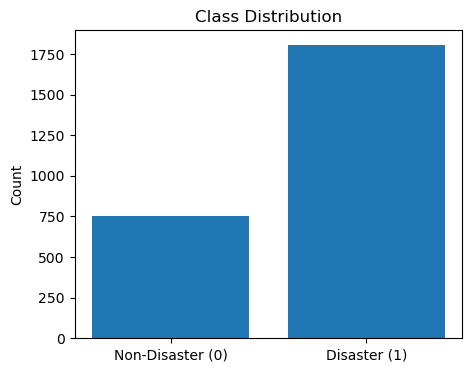

In [24]:
# Visualize class balance (EDA)
# This helps understand if the dataset is imbalanced.
counts = df["label"].value_counts().sort_index()

plt.figure(figsize=(5,4))
plt.bar(["Non-Disaster (0)", "Disaster (1)"], [counts[0], counts[1]])
plt.title("Class Distribution")
plt.ylabel("Count")
plt.show()


### Train-Test-Validation Split

In [27]:
from sklearn.model_selection import train_test_split

# Fix random seed for reproducibility (same split every run)
set_seed(42)

train_df, test_df = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df["label"]
)

train_df, val_df = train_test_split(
    train_df, test_size=0.2, random_state=42, stratify=train_df["label"]
)

print("Train:", train_df.shape, "Val:", val_df.shape, "Test:", test_df.shape)


Train: (1637, 3) Val: (410, 3) Test: (512, 3)


### Convert to HuggingFace Dataset

In [30]:
# Convert pandas DataFrames into HuggingFace Dataset objects.
# Trainer works best with HF datasets.
train_ds = Dataset.from_pandas(train_df.reset_index(drop=True))
val_ds   = Dataset.from_pandas(val_df.reset_index(drop=True))
test_ds  = Dataset.from_pandas(test_df.reset_index(drop=True))

train_ds[0]


{'Tweets': '#Earthquake (#землетрясение) M5.4 occurred 36 km S of #Almaty (#Kazakhstan) 8 min ago (local time 12:22:06). More info at:https://emsc-csem.org/lastquake/how_it_works/lastquake_app/…https://m.emsc.eu/?id=1629442https://emsc-csem.org/Earthquake_information/earthquake.php?id=1629442…',
 'Disaster': 'Disaster',
 'label': 1}

#### Tokenizer + Tokenize function

In [33]:
# Load pretrained tokenizer for DistilBERT.
# Tokenizer converts text -> tokens that the model understands.
MODEL_NAME = "distilbert-base-uncased"

# Tokenization function (applied to dataset in batches)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_batch(batch):
    return tokenizer(batch["Tweets"], truncation=True)

# Apply tokenization to each split
train_ds = train_ds.map(tokenize_batch, batched=True)
val_ds   = val_ds.map(tokenize_batch, batched=True)
test_ds  = test_ds.map(tokenize_batch, batched=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


Map:   0%|          | 0/1637 [00:00<?, ? examples/s]

Map:   0%|          | 0/410 [00:00<?, ? examples/s]

Map:   0%|          | 0/512 [00:00<?, ? examples/s]

In [34]:
# Load pretrained DistilBERT and attach a classification head.
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [35]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)

    acc = accuracy_score(labels, preds)

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average="weighted", zero_division=0
    )

    return {
        "accuracy": acc,
        "precision_weighted": precision,
        "recall_weighted": recall,
        "f1_weighted": f1
    }


In [39]:
print("\n" + "="*60)
print("CONFIGURING TRAINING")
print("="*60)

training_args = TrainingArguments(
    output_dir="./results",

    # Training hyperparameters
    num_train_epochs=2,              
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,

    # Optimization
    warmup_steps=100,
    weight_decay=0.01,

    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_weighted",
    greater_is_better=True,

    # Logging
    logging_dir="./logs",
    logging_steps=50,
    logging_first_step=True,

    report_to="none"
)

print("Training configuration:")
print(f"  - Epochs: {training_args.num_train_epochs}")
print(f"  - Learning rate: {training_args.learning_rate}")
print(f"  - Batch size: {training_args.per_device_train_batch_size}")
print(f"  - Warmup steps: {training_args.warmup_steps}")
print(f"  - Weight decay: {training_args.weight_decay}")
print(f"  - Eval strategy: {training_args.eval_strategy}")



CONFIGURING TRAINING
Training configuration:
  - Epochs: 2
  - Learning rate: 2e-05
  - Batch size: 8
  - Warmup steps: 100
  - Weight decay: 0.01
  - Eval strategy: IntervalStrategy.EPOCH


In [41]:
# Trainer handles:
# - training loop
# - evaluation
# - saving best checkpoint
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()

C:\Users\ARCHANA\AppData\Local\Temp\ipykernel_15272\2563536131.py:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
C:\Users\ARCHANA\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,Precision Weighted,Recall Weighted,F1 Weighted
1,0.137200,0.094863,0.963415,0.963515,0.963415,0.963458
2,0.057200,0.061945,0.982927,0.983171,0.982927,0.982987


C:\Users\ARCHANA\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=410, training_loss=0.21815292253726867, metrics={'train_runtime': 441.3009, 'train_samples_per_second': 7.419, 'train_steps_per_second': 0.929, 'total_flos': 84162592540236.0, 'train_loss': 0.21815292253726867, 'epoch': 2.0})

In [42]:
# Evaluate on the test set after training is complete.
pred_out = trainer.predict(test_ds)

logits = pred_out.predictions
true_ids = pred_out.label_ids
pred_ids = np.argmax(logits, axis=1)

print("\nTEST Accuracy:", accuracy_score(true_ids, pred_ids))
print("\nClassification Report:")
print(classification_report(true_ids, pred_ids, target_names=["Non-Disaster", "Disaster"], zero_division=0))


C:\Users\ARCHANA\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



TEST Accuracy: 0.986328125

Classification Report:
              precision    recall  f1-score   support

Non-Disaster       0.97      0.99      0.98       151
    Disaster       0.99      0.99      0.99       361

    accuracy                           0.99       512
   macro avg       0.98      0.99      0.98       512
weighted avg       0.99      0.99      0.99       512



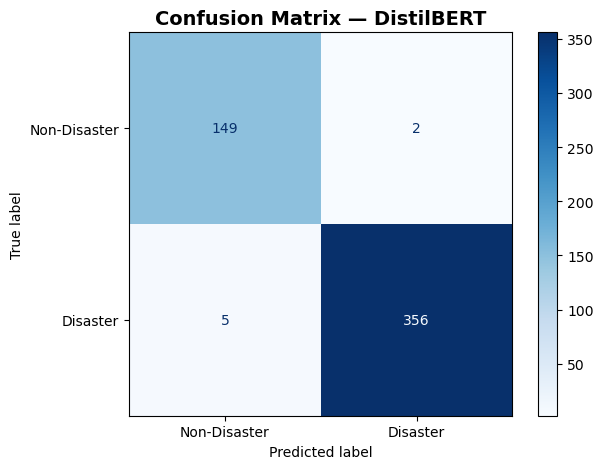

In [43]:
# Confusion matrix shows correct vs incorrect predictions
# Diagonal values represent correct predictions
cm = confusion_matrix(true_ids, pred_ids)

# Create ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Non-Disaster", "Disaster"]
)

# Plot with aesthetic color map
disp.plot(
    cmap="Blues",       
    values_format="d",  
    colorbar=True
)

plt.title("Confusion Matrix — DistilBERT", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()


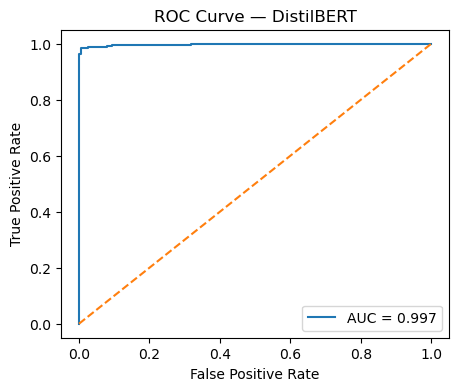

ROC-AUC: 0.9973950211883841


In [49]:
# ROC Curve evaluates performance across thresholds.
# We use the probability for class 1 (Disaster) as score.
probs = torch.softmax(torch.tensor(logits), dim=1).numpy()
pos_probs = probs[:, 1]

fpr, tpr, _ = roc_curve(true_ids, pos_probs)
auc = roc_auc_score(true_ids, pos_probs)

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — DistilBERT")
plt.legend()
plt.show()

print("ROC-AUC:", auc)


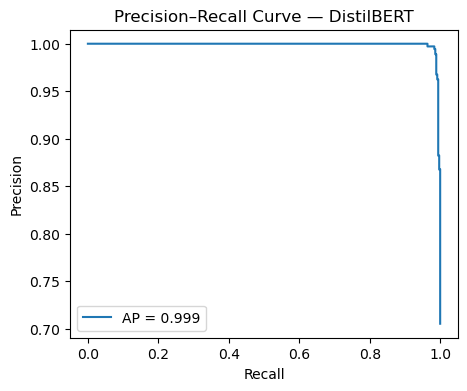

Average Precision (AP): 0.9990129580850775


In [51]:
# Precision-Recall curve is useful for imbalanced datasets.
# Average Precision (AP) summarizes PR curve performance.
prec, rec, _ = precision_recall_curve(true_ids, pos_probs)
ap = average_precision_score(true_ids, pos_probs)

plt.figure(figsize=(5,4))
plt.plot(rec, prec, label=f"AP = {ap:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve — DistilBERT")
plt.legend()
plt.show()

print("Average Precision (AP):", ap)


In [53]:
# Show sample predictions to demonstrate the model in action.
# Prints predicted class + confidence and compares with actual label.
sample_sentences = [
    "Earthquake destroyed many houses and people are injured.",
    "I love this new movie, it was amazing!",
    "The dinner tonight was simply amazing!",
    "Just finished my dinner and going to sleep now.",
    "Wildfire spreading fast due to strong winds."
]

# Put the ACTUAL labels here (what you believe is correct)
# 0 = Non-Disaster, 1 = Disaster
actual_labels = [1, 0, 0, 0, 1]

inputs = tokenizer(sample_sentences, padding=True, truncation=True, return_tensors="pt")
inputs = {k: v.to(model.device) for k, v in inputs.items()}

model.eval()
with torch.no_grad():
    outputs = model(**inputs)
    probs = torch.softmax(outputs.logits, dim=1).cpu().numpy()   # probabilities
    preds = np.argmax(probs, axis=1)

label_names = {0: "Non-Disaster", 1: "Disaster"}

print("\nSample Predictions with Confidence + Actual Label:\n")

for text, pred, prob, actual in zip(sample_sentences, preds, probs, actual_labels):
    conf = prob[pred] * 100
    print(f"Text: {text}")
    print(f"Actual:     {label_names[int(actual)]}")
    print(f"Predicted:  {label_names[int(pred)]}  ({conf:.2f}%)")
    print(f"Probabilities -> Non-Disaster: {prob[0]*100:.2f}% | Disaster: {prob[1]*100:.2f}%")
    print("-"*70)


Sample Predictions with Confidence + Actual Label:

Text: Earthquake destroyed many houses and people are injured.
Actual:     Disaster
Predicted:  Disaster  (99.77%)
Probabilities -> Non-Disaster: 0.23% | Disaster: 99.77%
----------------------------------------------------------------------
Text: I love this new movie, it was amazing!
Actual:     Non-Disaster
Predicted:  Non-Disaster  (65.71%)
Probabilities -> Non-Disaster: 65.71% | Disaster: 34.29%
----------------------------------------------------------------------
Text: The dinner tonight was simply amazing!
Actual:     Non-Disaster
Predicted:  Non-Disaster  (67.14%)
Probabilities -> Non-Disaster: 67.14% | Disaster: 32.86%
----------------------------------------------------------------------
Text: Just finished my dinner and going to sleep now.
Actual:     Non-Disaster
Predicted:  Non-Disaster  (78.65%)
Probabilities -> Non-Disaster: 78.65% | Disaster: 21.35%
--------------------------------------------------------------------

In [55]:
SAVE_DIR = "distilbert_disaster_model"
model.save_pretrained(SAVE_DIR)
tokenizer.save_pretrained(SAVE_DIR)

print("Saved model + tokenizer to:", SAVE_DIR)


Saved model + tokenizer to: distilbert_disaster_model
